# Iterative Soft-Thresholding Algorithm
In this notebook we simualte the classic optimization method known as the iterative soft-thresholding algorithm (ISTA).

ISTA is a special case of the proximal gradient descent method applied to the LASSO objective
\begin{equation}
	     f_{\rm LASSO}({\boldsymbol x}) = \mathop{\arg\min}\limits_{\boldsymbol s} \frac{1}{2}\|{\boldsymbol x}-{\boldsymbol H}{\boldsymbol s}\|^2 +\rho\|{\boldsymbol s}\|_1.
\end{equation}
Thus, the objective parameters are 
	\begin{equation} 
	    {\boldsymbol \theta}^{\rm o} = \{{\boldsymbol H}, \rho\}.
	\end{equation}





In [ ]:
import numpy as np
from scipy.linalg import orth
import matplotlib.pyplot as plt
import torch.nn as nn

np.random.seed(0)


ISTA solves the LASSO objective by taking the grdient in the $\ell_2$ term, i.e., 
\begin{equation}
	    \nabla_{{\boldsymbol s}}\frac{1}{2}\|{\boldsymbol x}-{\boldsymbol H}{\boldsymbol s}\|^2 = -{\boldsymbol H}^T({\boldsymbol x}-{\boldsymbol H}{\boldsymbol s}).
\end{equation}
Then, it applies the proximal mapping with respect to the $\ell_1$ norm, which is the soft-thresholding (shrinkage) operation
    \begin{equation}
        \mathcal{T}_{\beta}(x) \triangleq {\rm sign}(x)\max(0,|x|-\beta). 
    \end{equation}

The resulting update equation with step-size $\mu$ is given by 
   \begin{equation} 
         {\boldsymbol s}^{(k+1)} \leftarrow  \mathcal{T}_{\mu\rho}\left( {\boldsymbol s}^{(k)} + \mu {\boldsymbol H}^T({\boldsymbol x}-{\boldsymbol H}{\boldsymbol s}^{(k)}) \right).
    \end{equation}

In [ ]:
# ISTA
class ISTA(nn.Module):
    def __init__(self, H, mu, rho, max_iter, eps):
        super(ISTA, self).__init__()
   
        # Objective parameters
        self.H = H        
        self.rho = rho
        # Solver parameters
        self.mu = mu
        self.max_iter = max_iter
        self.eps = eps
 
        # initial estimate
        self.s = np.zeros((H.shape[1], 1)) 


    def shrinkage(self, x, beta): 
        return np.multiply(np.sign(x), np.maximum(np.abs(x)-beta, 0))

    def forward(self, x):
        recovery_errors =  [ ] 
 
        for ii in  range(self.max_iter): 
          s_prev = self.s
          # proximal gradient step
          temp = np.dot(self.H, s_prev) - x    
          g_grad = s_prev - np.multiply(self.mu,np.dot(self.H.T, temp)) 
          self.s = self.shrinkage(g_grad, np.multiply(self.mu,self.rho)) 
          # cease if convergence achieved
          if np.sum(np.abs( self.s- s_prev )) <= self.eps :  break 
          # save recovery error 
          recovery_errors.append(np.sum((np.dot(self.H, self.s) - x)**2))
          
        return self.s, recovery_errors

The LASSO objective is on its own a relaxation of the (non-convex) ojective
\begin{equation}
	    \mathop{\arg\min}\limits_{\boldsymbol s} \frac{1}{2}\|{\boldsymbol x}-{\boldsymbol H}{\boldsymbol s}\|^2 +\rho\|{\boldsymbol s}\|_0,
\end{equation}
which represents a *sparse recovery* setting, i.e., seeking a sparse vector $\boldsymbol s$ which matches the observations in the sense of minimizing $\|{\boldsymbol x}-{\boldsymbol H}{\boldsymbol s}\|^2$. Consequently, the data we are going to evaluate ISTA on will be that of a sparse vector measured with Gaussian noise, namely, we generate $\boldsymbol s$ such that 
\begin{equation}
\|{\boldsymbol s}\|_0= k,
\end{equation}
and 
\begin{equation}
{\boldsymbol x}= {\boldsymbol H}{\boldsymbol s} + {\boldsymbol w}, \qquad {\boldsymbol w}\sim \mathcal{N}(0,{\boldsymbol I}).
\end{equation}

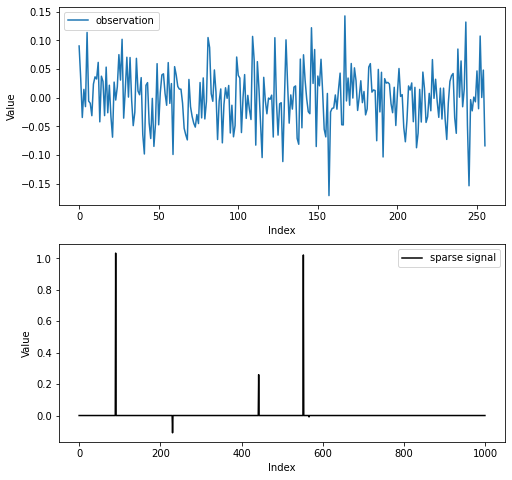

In [ ]:
# dimensions of the sparse signal, measurement and sparsity level
m , n , k =  1000 ,  256 ,  5 
Psi = np.eye(m) 
Phi = np.random.randn(n, m ) 
Phi = np.transpose(orth(np.transpose(Phi))) 
H = Phi
#H = np.dot(Phi, Psi)
#H = np.random.randn(n, m ) 

# Generate sparse signal 
s = np.zeros((1, m)) 
index_k = np.random.choice(m , k , replace = False) 
s[:,index_k] =  0.5 *np.random.randn(k,1).reshape([1 ,k ]) 
x = np.dot(H, s.T) + 0.01*np.random.randn(n, 1) 

plt.figure(figsize=(8, 8)) 
plt.subplot(2, 1, 1) 
plt.plot(x, label = 'observation' ) 
plt.xlabel('Index', fontsize=10)
plt.ylabel('Value', fontsize=10)
plt.legend( )
plt.subplot (2, 1, 2) 
plt.plot(s[0], label = 'sparse signal', color='k')  
plt.xlabel('Index', fontsize=10)
plt.ylabel('Value', fontsize=10)
plt.legend( )
plt.show()

We can see that while the high-dimensional vector is saprse, its lower-dimensional observations do not share this property.

### Apply iterative optimizer
Next, let's apply the model-based iterative optimizer

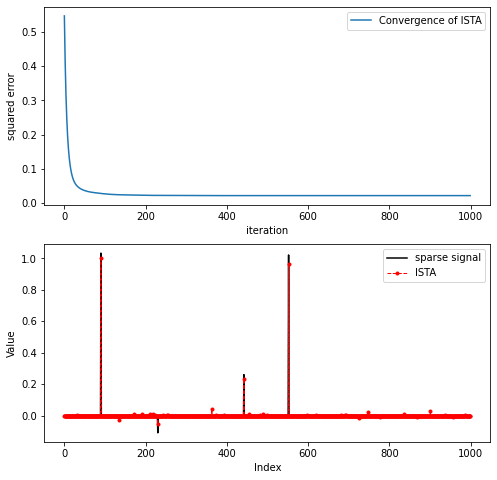

In [ ]:
step_size = 0.1
max_iter = 1000
rho = 0.01
eps_threshold = 1e-7

ISTA_model = ISTA(H, step_size, rho, max_iter, eps_threshold)

s_ISTA, errors = ISTA_model(x)

plt.figure(figsize=(8, 8)) 
plt.subplot(2, 1, 1) 
plt.plot(errors, label = 'Convergence of ISTA' ) 
plt.xlabel('iteration', fontsize=10)
plt.ylabel('squared error', fontsize=10)
plt.legend( )
plt.subplot (2, 1, 2) 
plt.plot(s[0], label = 'sparse signal', color='k') 
plt.plot ( s_ISTA ,  '.--' , label ='ISTA', color='r',linewidth=1) 
plt.xlabel('Index', fontsize=10)
plt.ylabel('Value', fontsize=10)
plt.legend( )
plt.show()

ISTA appears to be working quite well. However, much depends on the setting of the objective parameters, as we see in the following exmaple:

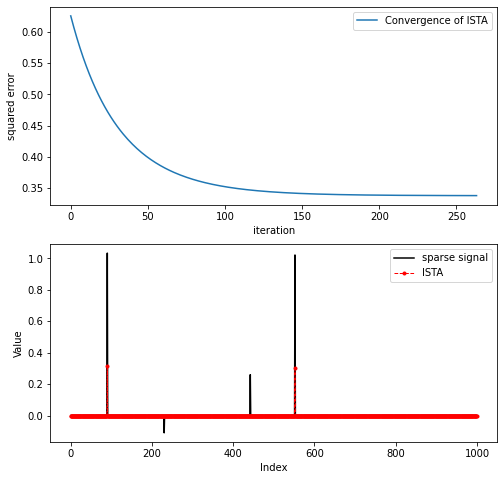

In [ ]:
rho2 = 0.2

ISTA_model2 = ISTA(H, step_size, rho2, max_iter, eps_threshold)

s_ISTA, errors = ISTA_model2(x)

plt.figure(figsize=(8, 8)) 
plt.subplot(2, 1, 1) 
plt.plot(errors, label = 'Convergence of ISTA' ) 
plt.xlabel('iteration', fontsize=10)
plt.ylabel('squared error', fontsize=10)
plt.legend( )
plt.subplot (2, 1, 2) 
plt.plot(s[0], label = 'sparse signal', color='k') 
plt.plot ( s_ISTA ,  '.--' , label ='ISTA', color='r',linewidth=1) 
plt.xlabel('Index', fontsize=10)
plt.ylabel('Value', fontsize=10)
plt.legend( )
plt.show()